***
# Edge Inference
## Edge inference by using OpenVINO™
***
In this exercise, OpenVINO™ will be introduced.  
Let us discover how to:
* convert from PyTorch (our pretrainined efficientNet-B1) to ONNX
* convert from ONNX to IR
* inference by using CPU, iGPU, dGPU
* compress to FP16
* benchmarking app

Prerequisite: OpenVINO™ Development Tools 
Install OpenVINO™ Development Tools - https://docs.openvino.ai/2023.1/openvino_docs_install_guides_install_dev_tools.html#install-dev-tools

In [1]:
# Import all the neccessary libraries
!pip install onnx
import torch
import torch.nn as nn
import numpy as np
import openvino as ov
from torchvision import models
#from model.ipynb import build_model
import intel_extension_for_pytorch as ipex
from pathlib import Path
import cv2
from scipy.special import softmax
#from class_names import class_names
import time
import matplotlib.pyplot as plt
from typing import List, Optional
import subprocess
import re
import os
#from utils import get_model_size, run_benchmark


[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


/home/user/bootcampq42023_env/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: ''If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


## Defined class names

In [3]:
class_names = ['AM General Hummer SUV 2000', 'Acura Integra Type R 2001', 
'Acura RL Sedan 2012', 'Acura TL Sedan 2012', 'Acura TL Type-S 2008', 
'Acura TSX Sedan 2012', 'Acura ZDX Hatchback 2012', 
'Aston Martin V8 Vantage Convertible 2012', 'Aston Martin V8 Vantage Coupe 2012', 
'Aston Martin Virage Convertible 2012', 'Aston Martin Virage Coupe 2012', 
'Audi 100 Sedan 1994', 'Audi 100 Wagon 1994', 'Audi A5 Coupe 2012', 
'Audi R8 Coupe 2012', 'Audi RS 4 Convertible 2008', 'Audi S4 Sedan 2007', 
'Audi S4 Sedan 2012', 'Audi S5 Convertible 2012', 'Audi S5 Coupe 2012', 
'Audi S6 Sedan 2011', 'Audi TT Hatchback 2011', 'Audi TT RS Coupe 2012',
 'Audi TTS Coupe 2012', 'Audi V8 Sedan 1994', 'BMW 1 Series Convertible 2012', 
 'BMW 1 Series Coupe 2012', 'BMW 3 Series Sedan 2012', 'BMW 3 Series Wagon 2012', 
 'BMW 6 Series Convertible 2007', 'BMW ActiveHybrid 5 Sedan 2012', 
 'BMW M3 Coupe 2012', 'BMW M5 Sedan 2010', 'BMW M6 Convertible 2010', 
 'BMW X3 SUV 2012', 'BMW X5 SUV 2007', 'BMW X6 SUV 2012', 
 'BMW Z4 Convertible 2012', 'Bentley Arnage Sedan 2009', 
 'Bentley Continental Flying Spur Sedan 2007', 
 'Bentley Continental GT Coupe 2007', 'Bentley Continental GT Coupe 2012', 
 'Bentley Continental Supersports Conv. Convertible 2012', 
 'Bentley Mulsanne Sedan 2011', 'Bugatti Veyron 16.4 Convertible 2009', 
 'Bugatti Veyron 16.4 Coupe 2009', 'Buick Enclave SUV 2012', 
 'Buick Rainier SUV 2007', 'Buick Regal GS 2012', 'Buick Verano Sedan 2012', 
 'Cadillac CTS-V Sedan 2012', 'Cadillac Escalade EXT Crew Cab 2007', 
 'Cadillac SRX SUV 2012', 'Chevrolet Avalanche Crew Cab 2012', 
 'Chevrolet Camaro Convertible 2012', 'Chevrolet Cobalt SS 2010', 
 'Chevrolet Corvette Convertible 2012', 
 'Chevrolet Corvette Ron Fellows Edition Z06 2007', 
 'Chevrolet Corvette ZR1 2012', 'Chevrolet Express Cargo Van 2007', 
 'Chevrolet Express Van 2007', 'Chevrolet HHR SS 2010', 
 'Chevrolet Impala Sedan 2007', 'Chevrolet Malibu Hybrid Sedan 2010', 
 'Chevrolet Malibu Sedan 2007', 'Chevrolet Monte Carlo Coupe 2007', 
 'Chevrolet Silverado 1500 Classic Extended Cab 2007', 
 'Chevrolet Silverado 1500 Extended Cab 2012', 
 'Chevrolet Silverado 1500 Hybrid Crew Cab 2012', 
 'Chevrolet Silverado 1500 Regular Cab 2012', 
 'Chevrolet Silverado 2500HD Regular Cab 2012', 
 'Chevrolet Sonic Sedan 2012', 'Chevrolet Tahoe Hybrid SUV 2012', 
 'Chevrolet TrailBlazer SS 2009', 'Chevrolet Traverse SUV 2012', 
 'Chrysler 300 SRT-8 2010', 'Chrysler Aspen SUV 2009', 
 'Chrysler Crossfire Convertible 2008', 
 'Chrysler PT Cruiser Convertible 2008', 
 'Chrysler Sebring Convertible 2010', 
 'Chrysler Town and Country Minivan 2012', 
 'Daewoo Nubira Wagon 2002', 
 'Dodge Caliber Wagon 2007', 'Dodge Caliber Wagon 2012', 
 'Dodge Caravan Minivan 1997', 'Dodge Challenger SRT8 2011', 
 'Dodge Charger SRT-8 2009', 'Dodge Charger Sedan 2012', 
 'Dodge Dakota Club Cab 2007', 'Dodge Dakota Crew Cab 2010', 
 'Dodge Durango SUV 2007', 'Dodge Durango SUV 2012', 
 'Dodge Journey SUV 2012', 'Dodge Magnum Wagon 2008', 
 'Dodge Ram Pickup 3500 Crew Cab 2010', 
 'Dodge Ram Pickup 3500 Quad Cab 2009', 
 'Dodge Sprinter Cargo Van 2009', 'Eagle Talon Hatchback 1998', 
 'FIAT 500 Abarth 2012', 'FIAT 500 Convertible 2012', 
 'Ferrari 458 Italia Convertible 2012', 'Ferrari 458 Italia Coupe 2012', 
 'Ferrari California Convertible 2012', 
 'Ferrari FF Coupe 2012', 'Fisker Karma Sedan 2012', 
 'Ford E-Series Wagon Van 2012', 'Ford Edge SUV 2012', 
 'Ford Expedition EL SUV 2009', 'Ford F-150 Regular Cab 2007', 
 'Ford F-150 Regular Cab 2012', 'Ford F-450 Super Duty Crew Cab 2012', 
 'Ford Fiesta Sedan 2012', 'Ford Focus Sedan 2007', 
 'Ford Freestar Minivan 2007', 'Ford GT Coupe 2006', 
 'Ford Mustang Convertible 2007', 'Ford Ranger SuperCab 2011', 
 'GMC Acadia SUV 2012', 'GMC Canyon Extended Cab 2012', 
 'GMC Savana Van 2012', 'GMC Terrain SUV 2012', 'GMC Yukon Hybrid SUV 2012', 
 'Geo Metro Convertible 1993', 'HUMMER H2 SUT Crew Cab 2009', 
 'HUMMER H3T Crew Cab 2010', 'Honda Accord Coupe 2012',
 'Honda Accord Sedan 2012', 'Honda Odyssey Minivan 2007', 
 'Honda Odyssey Minivan 2012', 'Hyundai Accent Sedan 2012', 
 'Hyundai Azera Sedan 2012', 'Hyundai Elantra Sedan 2007', 
 'Hyundai Elantra Touring Hatchback 2012', 'Hyundai Genesis Sedan 2012', 
 'Hyundai Santa Fe SUV 2012', 'Hyundai Sonata Hybrid Sedan 2012', 
 'Hyundai Sonata Sedan 2012', 'Hyundai Tucson SUV 2012', 
 'Hyundai Veloster Hatchback 2012', 'Hyundai Veracruz SUV 2012', 
 'Infiniti G Coupe IPL 2012', 'Infiniti QX56 SUV 2011', 
 'Isuzu Ascender SUV 2008', 'Jaguar XK XKR 2012', 'Jeep Compass SUV 2012', 
 'Jeep Grand Cherokee SUV 2012', 'Jeep Liberty SUV 2012', 
 'Jeep Patriot SUV 2012', 'Jeep Wrangler SUV 2012', 
 'Lamborghini Aventador Coupe 2012', 'Lamborghini Diablo Coupe 2001', 
 'Lamborghini Gallardo LP 570-4 Superleggera 2012', 
 'Lamborghini Reventon Coupe 2008', 'Land Rover LR2 SUV 2012', 
 'Land Rover Range Rover SUV 2012', 'Lincoln Town Car Sedan 2011', 
 'MINI Cooper Roadster Convertible 2012', 
 'Maybach Landaulet Convertible 2012', 'Mazda Tribute SUV 2011', 
 'McLaren MP4-12C Coupe 2012', 'Mercedes-Benz 300-Class Convertible 1993', 
 'Mercedes-Benz C-Class Sedan 2012', 'Mercedes-Benz E-Class Sedan 2012', 
 'Mercedes-Benz S-Class Sedan 2012', 'Mercedes-Benz SL-Class Coupe 2009', 
 'Mercedes-Benz Sprinter Van 2012', 'Mitsubishi Lancer Sedan 2012', 
 'Nissan 240SX Coupe 1998', 'Nissan Juke Hatchback 2012', 
 'Nissan Leaf Hatchback 2012', 'Nissan NV Passenger Van 2012', 
 'Plymouth Neon Coupe 1999', 'Porsche Panamera Sedan 2012', 
 'Ram C-V Cargo Van Minivan 2012', 'Rolls-Royce Ghost Sedan 2012', 
 'Rolls-Royce Phantom Drophead Coupe Convertible 2012', 
 'Rolls-Royce Phantom Sedan 2012', 'Scion xD Hatchback 2012', 
 'Spyker C8 Convertible 2009', 'Spyker C8 Coupe 2009', 
 'Suzuki Aerio Sedan 2007', 'Suzuki Kizashi Sedan 2012', 
 'Suzuki SX4 Hatchback 2012', 'Suzuki SX4 Sedan 2012', 
 'Tesla Model S Sedan 2012', 'Toyota 4Runner SUV 2012', 
 'Toyota Camry Sedan 2012', 'Toyota Corolla Sedan 2012', 
 'Toyota Sequoia SUV 2012', 'Volkswagen Beetle Hatchback 2012', 
 'Volkswagen Golf Hatchback 1991', 'Volkswagen Golf Hatchback 2012', 
 'Volvo 240 Sedan 1993', 'Volvo C30 Hatchback 2012', 
 'Volvo XC90 SUV 2007', 'smart fortwo Convertible 2012']

## Convert from PyTorch (.pth) to ONNX

In [4]:
def build_model(pretrained=True, fine_tune=True, num_classes=10):
    if pretrained:
        print('[INFO]: Loading pre-trained weights')
    else:
        print('[INFO]: Not loading pre-trained weights')
    model = models.efficientnet_b1(pretrained=pretrained)

    if fine_tune:
        print('[INFO]: Fine-tuning all layers...')
        for params in model.parameters():
            params.requires_grad = True
    elif not fine_tune:
        print('[INFO]: Freezing hidden layers...')
        for params in model.parameters():
            params.requires_grad = False

    # Change the final classification head.
    model.classifier[1] = nn.Linear(in_features=1280, out_features=num_classes)
    return model

In [6]:
# Initialize model, switch to eval model, load trained weights.
# Load the pre-trained efficientNet-B1 model
model = build_model(
   pretrained=False,
   fine_tune=False, 
   num_classes=196
)
# Load the trained weights and bias for Stanfort-Cars dataset
model.load_state_dict(torch.load('../outputs/good_model.pth', map_location={'0': 'xpu'}))
model.eval()
#convert from pytorch to onnx
dummy_input = torch.randn(1, 3, 224, 224)
torch.onnx.export(model, (dummy_input,), "model.onnx")
onnx_model = ov.convert_model("model.onnx")

[INFO]: Not loading pre-trained weights
[INFO]: Freezing hidden layers...
========== Diagnostic Run torch.onnx.export version 2.0.1a0+cxx11.abi ==========
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



## Convert from ONNX to FP32 IR

In [7]:
# .xml = model structure
# .bin = model weights
ov.save_model(onnx_model, "model_fp32.xml", compress_to_fp16=False)

## Preprocessing the image

In [8]:
# Normalize the image
def normalize(image: np.ndarray) -> np.ndarray:
    #Normalize the image to the given mean and standard deviation
    image = image.astype(np.float32)
    mean = (0.485, 0.456, 0.406)
    std = (0.229, 0.224, 0.225)
    image /= 255.0
    image -= mean
    image /= std
    return image

In [10]:
# Load image, resize it , and convert to the input shape of the network

image_filename = Path("BMW_Z4_2012.jpeg")

IMAGE_WIDTH=224
IMAGE_HEIGHT=224
image = cv2.cvtColor(cv2.imread(str(image_filename)), cv2.COLOR_BGR2RGB)
resized_image = cv2.resize(image, (IMAGE_WIDTH, IMAGE_HEIGHT))
normalized_image = normalize(resized_image)
# Convert the resized images to network input shape.
input_image = np.expand_dims(np.transpose(resized_image, (2, 0, 1)), 0)
normalized_input_image = np.expand_dims(np.transpose(normalized_image, (2, 0, 1)), 0)

## Query OpenVINO™ detected devices for inference

In [11]:
core=ov.Core()
devices = core.available_devices
for device_name in devices:
    device_info = core.get_property(device_name, "FULL_DEVICE_NAME")
    print(f"{device_name}: {device_info}")
    print("-" * 50)

CPU: 13th Gen Intel(R) Core(TM) i9-13900
--------------------------------------------------
GPU.0: Intel(R) UHD Graphics 770 (iGPU)
--------------------------------------------------
GPU.1: Intel(R) Arc(TM) A770 Graphics (dGPU)
--------------------------------------------------


## Start inference using OpenVINO™

In [12]:
device="GPU.1"

ov_model = core.read_model(model="model_fp32.xml")
ov_model.reshape([1, 3, 224, 224])
# Prepare model by selecting the inference device
compiled_model_ir = core.compile_model(model=ov_model, device_name=device)
# Get model information - input and output layers.
output_layer_ir = compiled_model_ir.output(0)
#  Do inference
start = time.perf_counter()
result = compiled_model_ir([normalized_input_image])[output_layer_ir]
end = time.perf_counter()
time_ir = end - start
print("Inference duration in second:",time_ir)

Inference duration in second: 0.009275845950469375


## Read inference result for FP32 IR format

Inference device: GPU.1
Predicted Class Name: 
BMW Z4 Convertible 2012; Score: 0.7666200399398804
BMW M6 Convertible 2010; Score: 0.1423654705286026
BMW 1 Series Convertible 2012; Score: 0.055751122534275055
BMW 6 Series Convertible 2007; Score: 0.02174733765423298
Bentley Continental Supersports Conv. Convertible 2012; Score: 0.001987570896744728


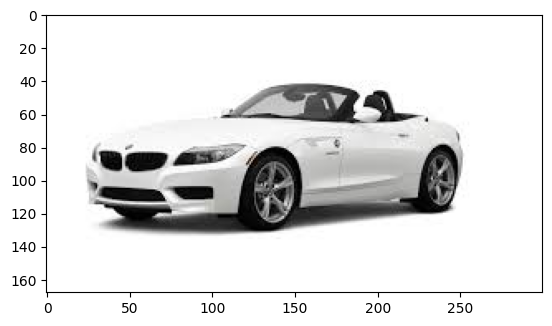

In [13]:
softmaxed_scores = softmax(result, -1)[0]
topk_labels = np.argsort(softmaxed_scores)[-5:][::-1]
topk_scores = softmaxed_scores[topk_labels]
plt.imshow(image)
print("Inference device:" , device)
print("Predicted Class Name: ")
for label, score in zip(topk_labels, topk_scores):
    pred_class_name = str(class_names[int(label)])
    print(f"{pred_class_name}; Score: {score}")

## Optimize FP32 IR model to FP16

In [14]:
ov.save_model(ov_model, "model_fp16.xml", compress_to_fp16=True)

#Load FP16 IR model
ov_fp16_model = core.read_model(model="model_fp16.xml")
ov_model.reshape([1, 3, 224, 224])
# Prepare model by selecting the inference device
compiled_fp16_model_ir = core.compile_model(model=ov_fp16_model, device_name=device)
# Get model information - input and output layers.
output_layer_ir = compiled_fp16_model_ir.output(0)
#  Do inference
start = time.perf_counter()
result = compiled_fp16_model_ir([normalized_input_image])[output_layer_ir]
end = time.perf_counter()
time_ir = end - start
print("Inference duration in second:", time_ir)

Inference duration in second: 0.008612659061327577


## Read inference result for FP16 IR format

Inference device: GPU.1
Predicted Class Name: 
BMW Z4 Convertible 2012; Score: 0.7666200399398804
BMW M6 Convertible 2010; Score: 0.1423654705286026
BMW 1 Series Convertible 2012; Score: 0.055751122534275055
BMW 6 Series Convertible 2007; Score: 0.02174733765423298
Bentley Continental Supersports Conv. Convertible 2012; Score: 0.001987570896744728


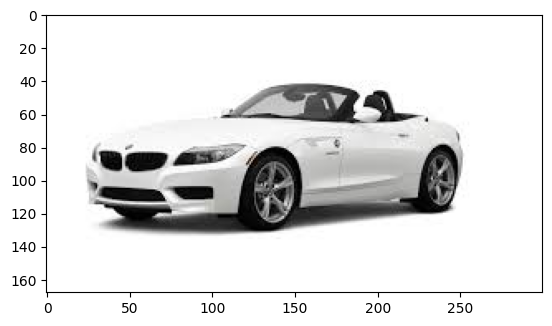

In [15]:
softmaxed_scores = softmax(result, -1)[0]
topk_labels = np.argsort(softmaxed_scores)[-5:][::-1]
topk_scores = softmaxed_scores[topk_labels]
plt.imshow(image)
print("Inference device:" , device)
print("Predicted Class Name: ")
for label, score in zip(topk_labels, topk_scores):
    pred_class_name = str(class_names[int(label)])
    print(f"{pred_class_name}; Score: {score}")


## Check the footprint for FP32 vs FP16 IR format

In [16]:
def get_model_size(ir_path: str, m_type: str = "Mb", verbose: bool = True) -> float:
    xml_size = os.path.getsize(ir_path)
    bin_size = os.path.getsize(os.path.splitext(ir_path)[0] + ".bin")
    for t in ["bytes", "Kb", "Mb"]:
        if m_type == t:
            break
        xml_size /= 1024
        bin_size /= 1024
    model_size = xml_size + bin_size
    if verbose:
        print(f"Model graph (xml):   {xml_size:.3f} Mb")
        print(f"Model weights (bin): {bin_size:.3f} Mb")
        print(f"Model size:          {model_size:.3f} Mb")
    return model_size

In [17]:
print("FP32 IR format footprint:")
fp32_model_size = get_model_size("model_fp32.xml", verbose=True)
print("FP16 IR format footprint:")
fp16_model_size = get_model_size("model_fp16.xml", verbose=True)

FP32 IR format footprint:
Model graph (xml):   0.350 Mb
Model weights (bin): 25.685 Mb
Model size:          26.035 Mb
FP16 IR format footprint:
Model graph (xml):   0.477 Mb
Model weights (bin): 12.843 Mb
Model size:          13.320 Mb


## Edge inference performance with OpenVINO™

In [18]:
def run_benchmark(model_path: str, device:str, shape: Optional[List[int]] = None, verbose: bool = True) -> float:
    command = f"benchmark_app -m {model_path} -d {device} -api async -t 15"
    if shape is not None:
        command += f' -shape [{",".join(str(x) for x in shape)}]'
    cmd_output = subprocess.check_output(command, shell=True)  # nosec
    if verbose:
        print(*str(cmd_output).split("\\n")[-2:-1], sep="\n")
    match = re.search(r"Throughput\: (.+?) FPS", str(cmd_output))
    return float(match.group(1))

In [19]:
# Inference FP32 model (OpenVINO IR)
print("FP32 CPU:")
run_benchmark("model_fp32.xml", "CPU", shape=[1, 3, 224, 224], verbose=True)

print("FP16 CPU:")
run_benchmark("model_fp16.xml", "CPU", shape=[1, 3, 224, 224], verbose=True)

print("FP32 GPU.0:")
run_benchmark("model_fp32.xml", "GPU.0", shape=[1, 3, 224, 224], verbose=True)

print("FP16 GPU.0:")
run_benchmark("model_fp16.xml", "GPU.0", shape=[1, 3, 224, 224], verbose=True)

print("FP32 GPU.1:")
run_benchmark("model_fp32.xml", "GPU.1", shape=[1, 3, 224, 224], verbose=True)

print("FP16 GPU.1:")
run_benchmark("model_fp16.xml", "GPU.1", shape=[1, 3, 224, 224], verbose=True)

FP32 CPU:
[ INFO ] Throughput:   686.38 FPS
FP16 CPU:
[ INFO ] Throughput:   672.88 FPS
FP32 GPU.0:
[ INFO ] Throughput:   266.65 FPS
FP16 GPU.0:
[ INFO ] Throughput:   266.04 FPS
FP32 GPU.1:
[ INFO ] Throughput:   1378.89 FPS
FP16 GPU.1:
[ INFO ] Throughput:   1374.63 FPS


1374.63

## Notices & Disclaimers 
Intel technologies may require enabled hardware, software or service activation. 

No product or component can be absolutely secure.  

Your costs and results may vary.  

No license (express or implied, by estoppel or otherwise) to any intellectual property rights is granted by this document, with the sole exception that code included in this document is licensed subject to the Zero-Clause BSD open source license (0BSD), Open Source Initiative. No rights are granted to create modifications or derivatives of this document. 

© Intel Corporation.  Intel, the Intel logo, and other Intel marks are trademarks of Intel Corporation or its subsidiaries.  Other names and brands may be claimed as the property of others.